In [1]:
import yaml
import easydict
import os
from os.path import join
from google.colab import drive
import argparse

!pip install easydl
!pip install tensorboardX
from torchvision import models
from easydl import *
from collections import Counter
from torchvision.transforms.transforms import *
from torch.utils.data import DataLoader, WeightedRandomSampler

import datetime
from tqdm import tqdm
if is_in_notebook():
    from tqdm import tqdm_notebook as tqdm
from torch import optim
from tensorboardX import SummaryWriter
import torch.backends.cudnn as cudnn

  Created wheel for easydl: filename=easydl-2.0.7-py3-none-any.whl size=19797 sha256=635618b2d7d6779d34244d7f9647a31e176c2669c81194cdedbf23449bf45dab
  Stored in directory: /root/.cache/pip/wheels/05/e0/8f/b8456f938e69b862cecfa8f03f7a063cfb77a2f253ed28ce3a
Successfully built easydl
     |████████████████████████████████| 124 kB 5.2 MB/s 
[easydl] tensorflow not available!


In [2]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature
from PIL import Image

from google.colab import drive

In [4]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
os.chdir("/content/drive/MyDrive")

In [6]:
class Dataset:
    def __init__(self, path, domains, files, prefix):
        self.path = path
        self.prefix = prefix
        self.domains = domains
        self.files = [(join(path, file)) for file in files]
        self.prefixes = [self.prefix] * len(self.domains)


parser = argparse.ArgumentParser(description='Code for *Universal Domain Adaptation*',
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('-f')
parser.add_argument('--config', type=str, default='office-train-config.yaml', help='/path/to/config/file')

args = parser.parse_args()

config_file = args.config

args = yaml.safe_load(open(config_file))

save_config = yaml.safe_load(open(config_file))

args = easydict.EasyDict(args)

dataset = None
if args.data.dataset.name == 'office':
    dataset = Dataset(
    path=args.data.dataset.root_path,
    domains=['amazon', 'dslr', 'webcam'],
    files=[
        'amazon_reorgnized.txt',
        'dslr_reorgnized.txt',
        'webcam_reorgnized.txt'
    ],
    prefix=args.data.dataset.root_path)
    

In [ ]:
print(args.data.dataset)

{'name': 'office', 'root_path': 'data/office', 'source': 0, 'target': 1, 'n_share': 10, 'n_source_private': 10, 'n_total': 31}


In [7]:
source_domain_name = dataset.domains[args.data.dataset.source]
target_domain_name = dataset.domains[args.data.dataset.target]
source_file = dataset.files[args.data.dataset.source]
target_file = dataset.files[args.data.dataset.target]

In [ ]:
print(source_domain_name)
print(target_domain_name)
print(dataset.domains)

amazon
dslr
['amazon', 'dslr', 'webcam']


In [8]:
a, b, c = args.data.dataset.n_share, args.data.dataset.n_source_private, args.data.dataset.n_total
c = c - a - b
common_classes = [i for i in range(a)]
source_private_classes = [i + a for i in range(b)]
target_private_classes = [i + a + b for i in range(c)]

source_classes = common_classes + source_private_classes
target_classes = common_classes + target_private_classes

print(common_classes)
print(source_classes)
print(target_classes)

print(len(source_classes))
print(len(target_classes))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
20
21


In [9]:
source_classes = common_classes + source_private_classes
target_classes = common_classes + target_private_classes

train_transform = Compose([
    Resize(256),
    RandomCrop(224),
    RandomHorizontalFlip(),
    ToTensor()
])

test_transform = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor()
])

source_train_ds = FileListDataset(list_path=source_file, path_prefix=dataset.prefixes[args.data.dataset.source],
                            transform=train_transform, filter=(lambda x: x in source_classes))
source_test_ds = FileListDataset(list_path=source_file,path_prefix=dataset.prefixes[args.data.dataset.source],
                            transform=test_transform, filter=(lambda x: x in source_classes))
target_train_ds = FileListDataset(list_path=target_file, path_prefix=dataset.prefixes[args.data.dataset.target],
                            transform=train_transform, filter=(lambda x: x in target_classes))
target_test_ds = FileListDataset(list_path=target_file, path_prefix=dataset.prefixes[args.data.dataset.target],
                            transform=test_transform, filter=(lambda x: x in target_classes))



In [11]:
classes = source_train_ds.labels

freq = Counter(classes)
class_weight = {x : 1.0 / freq[x] if args.data.dataloader.class_balance else 1.0 for x in freq}

source_weights = [class_weight[x] for x in source_train_ds.labels]
sampler = WeightedRandomSampler(source_weights, len(source_train_ds.labels))

In [12]:


source_train_dl = DataLoader(dataset=source_train_ds, batch_size=args.data.dataloader.batch_size,
                             sampler=sampler, num_workers=args.data.dataloader.data_workers, drop_last=True)
source_test_dl = DataLoader(dataset=source_test_ds, batch_size=args.data.dataloader.batch_size, shuffle=False,
                             num_workers=1, drop_last=False)
target_train_dl = DataLoader(dataset=target_train_ds, batch_size=args.data.dataloader.batch_size,shuffle=True,
                             num_workers=args.data.dataloader.data_workers, drop_last=True)
target_test_dl = DataLoader(dataset=target_test_ds, batch_size=args.data.dataloader.batch_size, shuffle=False,
                             num_workers=1, drop_last=False)



In [13]:
def reverse_sigmoid(y):
    return torch.log(y / (1.0 - y + 1e-10) + 1e-10)


def get_source_share_weight(domain_out, before_softmax, domain_temperature=1.0, class_temperature=10.0):
    before_softmax = before_softmax / class_temperature
    after_softmax = nn.Softmax(-1)(before_softmax)
    domain_logit = reverse_sigmoid(domain_out)
    domain_logit = domain_logit / domain_temperature
    domain_out = nn.Sigmoid()(domain_logit)
    
    entropy = torch.sum(- after_softmax * torch.log(after_softmax + 1e-10), dim=1, keepdim=True)
    entropy_norm = entropy / np.log(after_softmax.size(1))
    weight = entropy_norm - domain_out
    weight = weight.detach()
    return weight


def get_target_share_weight(domain_out, before_softmax, domain_temperature=1.0, class_temperature=10.0):
    return - get_source_share_weight(domain_out, before_softmax, domain_temperature, class_temperature)


def normalize_weight(x):
    min_val = x.min()
    max_val = x.max()
    x = (x - min_val) / (max_val - min_val)
    x = x / torch.mean(x)
    return x.detach()


def seed_everything(seed=1234):
    import random
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

In [14]:
def outlier(each_target_share_weight):
    return each_target_share_weight < args.test.w_0


In [15]:
class BaseFeatureExtractor(nn.Module):
    def forward(self, *input):
        pass

    def __init__(self):
        super(BaseFeatureExtractor, self).__init__()

    def output_num(self):
        pass

    def train(self, mode=True):
        # freeze BN mean and std
        for module in self.children():
            if isinstance(module, nn.BatchNorm2d):
                module.train(False)
            else:
                module.train(mode)


class ResNet50Fc(BaseFeatureExtractor):
    """
    ** input image should be in range of [0, 1]**
    """
    def __init__(self,model_path=args.model.pretrained_model, normalize=True, canny=False):
        super(ResNet50Fc, self).__init__()
        if model_path:
            if os.path.exists(model_path):
                self.model_resnet = models.resnet50(pretrained=False)
                self.model_resnet.load_state_dict(torch.load(model_path))
            else:
                #print(args.model.pretrained_model)
                raise Exception('invalid model path!')
        else:
            self.model_resnet = models.resnet50(pretrained=True)

        if model_path or normalize:
            # pretrain model is used, use ImageNet normalization
            self.normalize = True
            self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
            self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        else:
            self.normalize = canny
        self.canny = False
        model_resnet = self.model_resnet
        self.conv1 = model_resnet.conv1
        self.bn1 = model_resnet.bn1
        self.relu = model_resnet.relu
        self.maxpool = model_resnet.maxpool
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3
        self.layer4 = model_resnet.layer4
        self.avgpool = model_resnet.avgpool
        self.__in_features = model_resnet.fc.in_features

    def forward(self, x):
        if self.normalize:
            x = (x - self.mean) / self.std
        if self.canny:
            #print(x.shape)
            x = torch.mean(x, axis=1)
            xx = x.cpu().detach().numpy()
            edges1 = np.array([feature.canny(i) for i in xx])        
            edges1 = np.stack((edges1,)*3, axis=1)
            x = torch.from_numpy(edges1)
            x = x.to('cuda', dtype=torch.float)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    def output_num(self):
        return self.__in_features


class CLS(nn.Module):
    """
    a two-layer MLP for classification
    """
    def __init__(self, in_dim, out_dim, bottle_neck_dim=256):
        super(CLS, self).__init__()
        self.bottleneck = nn.Linear(in_dim, bottle_neck_dim)
        self.fc = nn.Linear(bottle_neck_dim, out_dim)
        self.main = nn.Sequential(self.bottleneck, self.fc, nn.Softmax(dim=-1))

    def forward(self, x):
        out = [x]
        for module in self.main.children():
            x = module(x)
            out.append(x)
        return out


class AdversarialNetwork(nn.Module):
    def __init__(self, in_feature):
        super(AdversarialNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_feature, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024,1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        self.grl = GradientReverseModule(lambda step: aToBSheduler(step, 0.0, 1.0, gamma=10, max_iter=10000))

    def forward(self, x):
        x_ = self.grl(x)
        y = self.main(x_)
        return y

In [16]:
cudnn.benchmark = True
cudnn.deterministic = True

seed_everything()
torch.multiprocessing.freeze_support()
# if args.misc.gpus < 1:
#     import os
#     os.environ["CUDA_VISIBLE_DEVICES"] = ""
#     gpu_ids = []
#     output_device = torch.device('cpu')
# else:
#     gpu_ids = select_GPUs(args.misc.gpus)
#     output_device = gpu_ids[0]
gpu_ids = [0]
output_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(output_device)
#exit()
now = datetime.datetime.now().strftime('%b%d_%H-%M-%S')

log_dir = f'{args.log.root_dir}/{now}'
print(log_dir)
logger = SummaryWriter(log_dir)

# with open(join(log_dir, 'config.yaml'), 'w') as f:
#     f.write(yaml.dump(save_config))

model_dict = {
    'resnet50': ResNet50Fc,
}


class TotalNet(nn.Module):
    def __init__(self, canny):
        super(TotalNet, self).__init__()
        self.feature_extractor = ResNet50Fc(canny=canny)
        classifier_output_dim = len(source_classes)
        self.classifier = CLS(self.feature_extractor.output_num(), classifier_output_dim, bottle_neck_dim=256)
        self.discriminator = AdversarialNetwork(256)
        self.discriminator_separate = AdversarialNetwork(256)

    def forward(self, x):
        f = self.feature_extractor(x)
        f, _, __, y = self.classifier(f)
        d = self.discriminator(_)
        d_0 = self.discriminator_separate(_)
        return y, d, d_0






cuda
log/Nov07_07-08-23


In [17]:
totalNet = TotalNet(canny=False)

feature_extractor = nn.DataParallel(totalNet.feature_extractor, device_ids=gpu_ids, output_device=output_device).train(True)
classifier = nn.DataParallel(totalNet.classifier, device_ids=gpu_ids, output_device=output_device).train(True)
discriminator = nn.DataParallel(totalNet.discriminator, device_ids=gpu_ids, output_device=output_device).train(True)
discriminator_separate = nn.DataParallel(totalNet.discriminator_separate, device_ids=gpu_ids, output_device=output_device).train(True)


In [28]:
def test():
    counters = [AccuracyCounter() for x in range(len(source_classes) + 1)]
    mgr = TrainingModeManager([feature_extractor, classifier, discriminator_separate], train=False)
    target_accumulator =  Accumulator(['feature__', 'predict_prob', 'label', 'domain_prob', 'before_softmax',
                         'target_share_weight'])
    with   torch.no_grad():
        feature_extractor.eval()
        classifier.eval()
        discriminator.eval()
        discriminator_separate.eval()
        for i, (im, label) in enumerate(tqdm(target_test_dl, desc='testing ')):
            im = im.to(output_device)
            label = label.to(output_device)

            feature__ = feature_extractor.forward(im)
            feature__, __, before_softmax, predict_prob = classifier.forward(feature__)
            domain_prob = discriminator_separate.forward(__)

            target_share_weight = get_target_share_weight(domain_prob, before_softmax, domain_temperature=1.0,
                                                          class_temperature=1.0)
            

            for (each_predict_prob, each_label, each_target_share_weight) in zip(predict_prob, label, target_share_weight):
                if each_label in source_classes:
                    counters[each_label].Ntotal += 1.0
                    each_pred_id = torch.argmax(each_predict_prob)
                    if not outlier(each_target_share_weight[0]) and each_pred_id == each_label:
                        counters[each_label].Ncorrect += 1.0
                else:
                    counters[-1].Ntotal += 1.0
                    if outlier(each_target_share_weight[0]):
                        counters[-1].Ncorrect += 1.0

    acc_tests = [x.reportAccuracy() for x in counters if not np.isnan(x.reportAccuracy())]
    acc_test = torch.ones(1, 1) * np.mean(acc_tests)
    print(acc_tests)
    print(f'test accuracy is {acc_test.item()}')
 



In [18]:
data = torch.load(open('log/Nov06_20-41-42_van_nobatch/best.pkl', 'rb'), map_location=output_device)

In [19]:
feature_extractor.load_state_dict(data['feature_extractor'])
classifier.load_state_dict(data['classifier'])
discriminator.load_state_dict(data['discriminator'])
discriminator_separate.load_state_dict(data['discriminator_separate'])

<All keys matched successfully>

In [20]:
torch.cuda.empty_cache()

In [29]:
print('UAN_vanilla_nobatch')
test()

UAN_vanilla_nobatch


testing :   0%|          | 0/10 [00:00<?, ?it/s]

[1.0, 0.8095238095238095, 1.0, 0.8461538461538461, 0.8, 0.7916666666666666, 0.6818181818181818, 0.9166666666666666, 0.875, 0.4782608695652174, 0.34285714285714286]
test accuracy is 0.7765406370162964


In [30]:
data = torch.load(open('log/Nov06_19-13-56_van_batchnorm/best.pkl', 'rb'), map_location=output_device)

In [31]:
feature_extractor.load_state_dict(data['feature_extractor'])
classifier.load_state_dict(data['classifier'])
discriminator.load_state_dict(data['discriminator'])
discriminator_separate.load_state_dict(data['discriminator_separate'])

<All keys matched successfully>

In [32]:
print('UAN_vanilla_batch')
test()

UAN_vanilla_batch


testing :   0%|          | 0/10 [00:00<?, ?it/s]

[1.0, 0.9523809523809523, 1.0, 1.0, 0.9, 0.7916666666666666, 0.7272727272727273, 1.0, 1.0, 0.782608695652174, 0.21142857142857144]
test accuracy is 0.8513961434364319


In [33]:
data = torch.load(open('log/Nov06_10-08-58_canny/best.pkl', 'rb'), map_location=output_device)

In [34]:
feature_extractor.load_state_dict(data['feature_extractor'])
classifier.load_state_dict(data['classifier'])
discriminator.load_state_dict(data['discriminator'])
discriminator_separate.load_state_dict(data['discriminator_separate'])

<All keys matched successfully>

In [35]:
print('UAN_canny_batch')
test()

UAN_canny_batch


testing :   0%|          | 0/10 [00:00<?, ?it/s]

[1.0, 0.6666666666666666, 0.0, 1.0, 0.8, 0.75, 0.9090909090909091, 1.0, 1.0, 0.782608695652174, 0.42857142857142855]
test accuracy is 0.7579034566879272


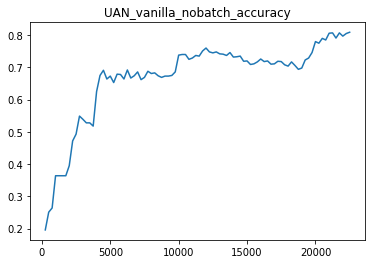

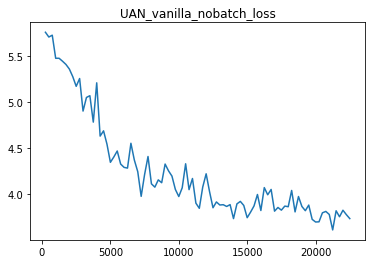

In [39]:
with open('log/Nov06_20-41-42_van_nobatch/epoch.txt') as f:
    lines = f.readlines()
accuracy = [float(i[:5]) for i in lines[5:95]]
loss = [float(i[:5]) for i in lines[97:]]
epoch = [(i+1) * 250 for i in range(90)]

plt.plot(epoch, accuracy)
plt.title('UAN_vanilla_nobatch_accuracy')
plt.show()

plt.plot(epoch, loss)
plt.title('UAN_vanilla_nobatch_loss')
plt.show()

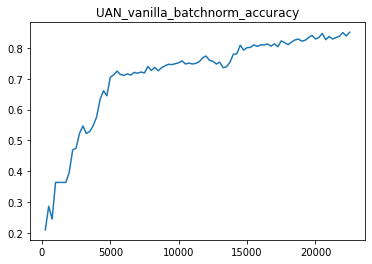

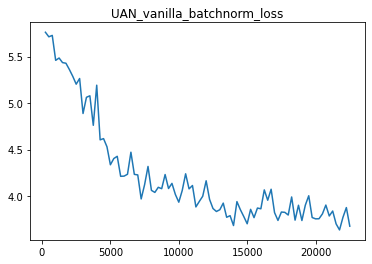

In [44]:
with open('log/Nov06_19-13-56_van_batchnorm/epoch.txt') as f:
    lines = f.readlines()
accuracy = [float(i[:5]) for i in lines[4:94]]
loss = [float(i[:5]) for i in lines[96:]]
epoch = [(i+1) * 250 for i in range(90)]

plt.plot(epoch, accuracy)
plt.title('UAN_vanilla_batchnorm_accuracy')
plt.show()

plt.plot(epoch, loss)
plt.title('UAN_vanilla_batchnorm_loss')
plt.show()

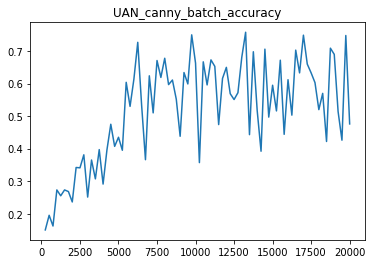

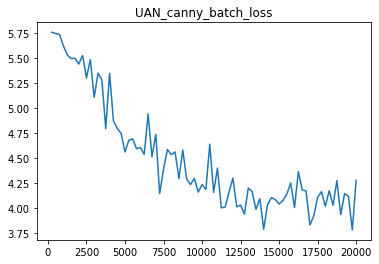

In [57]:
with open('log/Nov06_10-08-58_canny/epoch.txt') as f:
    lines = f.readlines()


accuracy = [float(i[:5]) for i in lines[4:84]]
loss = [float(i[:5]) for i in lines[86:]]
epoch = [(i+1) * 250 for i in range(80)]

plt.plot(epoch, accuracy)
plt.title('UAN_canny_batch_accuracy')
plt.show()

plt.plot(epoch, loss)
plt.title('UAN_canny_batch_loss')
plt.show()